<a href="https://colab.research.google.com/github/Cal723/CSE-337-Labs/blob/main/ChessEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install chess
!pip install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 80.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=be3f78f9511e69a4bebc0debec450d9373bc9eb73701c30d0c80adba6ed90a73
  Stored in directory: /root/.cache/pip/wheels/83/1f/4e/8f4300f7dd554eb8de70ddfed96e94d3d030ace10c5b53d447
Successfully built chess


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim


if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU available, using CPU.")


print("Number of GPUs:", torch.cuda.device_count())
print("MPS Available:", torch.backends.mps.is_available())

try:
    import torch_xla
    import torch_xla.core.xla_model as xm
    print("TPU Available:", xm.xla_device())
except ImportError:
    print("TPU not available.")

No GPU available, using CPU.
Number of GPUs: 0
MPS Available: False
TPU not available.


In [3]:
# import chess
# import torch
def board_to_tensor(board, turn):

    tensor = torch.zeros(13, 8, 8)

    for square in range(64):
        piece = board.piece_at(square)
        if piece:
            piece_type = piece.piece_type - 1
            color_offset = 0 if piece.color == chess.WHITE else 6
            tensor[color_offset + piece_type, square // 8, square % 8] = 1


    tensor[12, :, :] = turn


    return tensor


In [4]:
import chess
import torch

def get_legal_tensor(board):
    legal_move_list = list(board.legal_moves)
    move_tensor = torch.zeros(4352)
    for move in legal_move_list:
        from_square = move.from_square
        to_square = move.to_square
        piece = board.piece_at(from_square)
        idx = encode_move(move)
        move_tensor[idx] = 1
    return move_tensor

def get_row_col(square):
    row = square // 8
    col = square % 8
    return row, col

PROMOTION_PIECES = ['q', 'r', 'b', 'n']

def encode_move(move):
    from_square = move.from_square
    to_square = move.to_square

    if move.promotion is None:
        return from_square * 64 + to_square
    else:
        promotion_index = PROMOTION_PIECES.index(chess.piece_symbol(move.promotion))
        return 4096 + from_square * 4 + promotion_index

def decode_move(index):
    if index < 4096:
        from_square = index // 64
        to_square = index % 64
        return chess.Move(from_square, to_square)
    else:
        promotion_index = index - 4096
        from_square = promotion_index // 4
        promo_piece = PROMOTION_PIECES[promotion_index % 4]
        rank_offset = 8 if chess.square_rank(from_square) == 6 else -8
        to_square = from_square + rank_offset
        return chess.Move(from_square, to_square, promotion=chess.Piece.from_symbol(promo_piece).piece_type)


board = chess.Board()
legal_tensor = get_legal_tensor(board)
print(legal_tensor)

print(f"Shape of the tensor: {legal_tensor.shape}")
print(f"Type of the tensor: {legal_tensor.dtype}")

tensor([0., 0., 0.,  ..., 0., 0., 0.])
Shape of the tensor: torch.Size([4352])
Type of the tensor: torch.float32


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class DQN(nn.Module):
    def __init__(self, num_actions=4352):
        super(DQN, self).__init__()


        self.conv1 = nn.Conv2d(13, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)


        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, num_actions)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [16]:
import random
from collections import deque


class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)

replay_buffer = ReplayBuffer(10000)


def select_action(board, state, q_network, epsilon):
    legal_moves = list(board.legal_moves)

    if random.random() < epsilon:
        print("Exploration Move")
        move = random.choice(legal_moves)
        return encode_move(move)

    print("Predicted Move")
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

    q_values = q_network(state_tensor).squeeze(0)
    legal_move_mask = get_legal_tensor(board).to(device)

    q_values[legal_move_mask == 0] = -float('inf')

    best_move_index = torch.argmax(q_values).item()
    return best_move_index



def train(q_network, target_network, replay_buffer, batch_size, gamma, optimizer, criterion):
    if replay_buffer.size() < batch_size:
        return

    batch = replay_buffer.sample(batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.stack(states).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.stack(next_states).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    q_values = q_network(states).gather(1, actions).squeeze(1)
    with torch.no_grad():
        next_q_values = target_network(next_states).max(1)[0]
        expected_q_values = rewards + gamma * next_q_values * (1 - dones)

    loss = criterion(q_values, expected_q_values)
    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_norm_(q_network.parameters(), max_norm=1.0)

    optimizer.step()


In [7]:
!pip install sympy

In [ ]:
import chess
import chess.engine


stockfish_path = "/usr/games/stockfish"
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)
print("Stockfish loaded successfully!")

FileNotFoundError: [Errno 2] No such file or directory: '/usr/games/stockfish'

In [11]:
!apt-get update
!apt-get install stockfish

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:5 https://cli.github.com/packages stable InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,151 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/univers

In [8]:
!find / -name "stockfish" 2>/dev/null


In [9]:
def get_capture_reward(board, move):
    if board.is_capture(move):
        captured_piece = board.piece_at(move.to_square)
        if captured_piece:
            piece_type = captured_piece.piece_type
            reward_table = {
                chess.PAWN: 2.5,
                chess.KNIGHT: 5,
                chess.BISHOP: 5,
                chess.ROOK: 8,
                chess.QUEEN: 15
            }
            return reward_table.get(piece_type, 0)
    return 0


Episode 0
Move 1
Predicted Move
White (Agent) plays: b1c3
White move: b1c3
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . N . . . . .
P P P P P P P P
R . B Q K B N R

Stockfish thinking...
Black (Stockfish) plays: d7d5
Black move: d7d5
r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . p . . . .
. . . . . . . .
. . N . . . . .
P P P P P P P P
R . B Q K B N R

Move 2
Exploration Move
White (Agent) plays: a2a3
White move: a2a3
r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . p . . . .
. . . . . . . .
P . N . . . . .
. P P P P P P P
R . B Q K B N R

Stockfish thinking...


/tmp/ipython-input-379821394.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Streaming output truncated to the last 5000 lines.
p p . . . p p .
q . n . . n . p
. . . . p . . P
. . . p . . . .
. . . P . . P B
P . P p P P . .
. . R . K . N b

Move 19
Predicted Move
White (Agent) plays: e1d2
White move: e1d2
r . . . k b . r
p p . . . p p .
q . n . . n . p
. . . . p . . P
. . . p . . . .
. . . P . . P B
P . P K P P . .
. . R . . . N b

Stockfish thinking...
Black (Stockfish) plays: a6a2
Black move: a6a2
r . . . k b . r
p p . . . p p .
. . n . . n . p
. . . . p . . P
. . . p . . . .
. . . P . . P B
q . P K P P . .
. . R . . . N b

Move 20
Predicted Move
White (Agent) plays: h3c8
White move: h3c8
r . B . k b . r
p p . . . p p .
. . n . . n . p
. . . . p . . P
. . . p . . . .
. . . P . . P .
q . P K P P . .
. . R . . . N b

Stockfish thinking...
Black (Stockfish) plays: a8c8
Black move: a8c8
. . r . k b . r
p p . . . p p .
. . n . . n . p
. . . . p . . P
. . . p . . . .
. . . P . . P .
q . P K P P . .
. . R . . . N b

Training on replay buffer

Training complete

Move

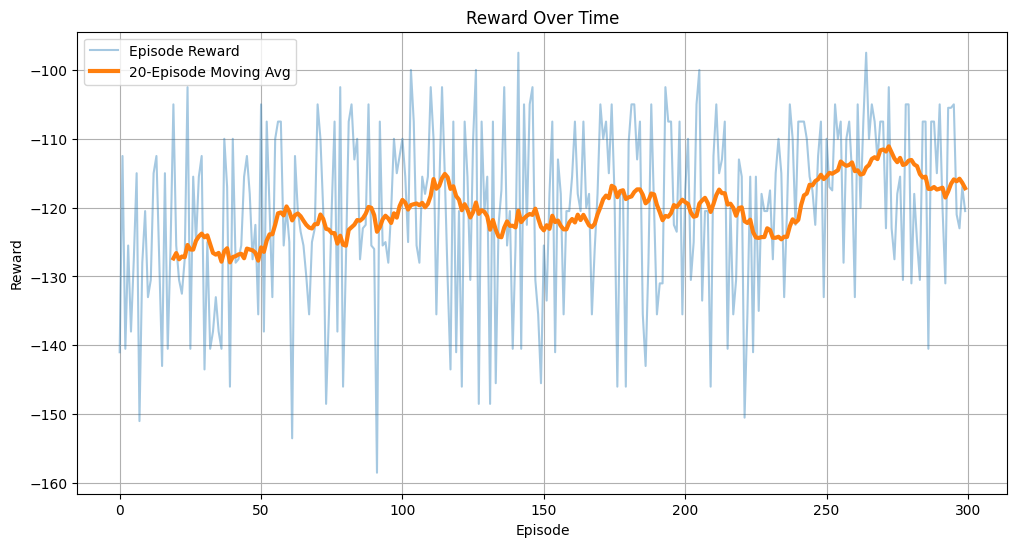

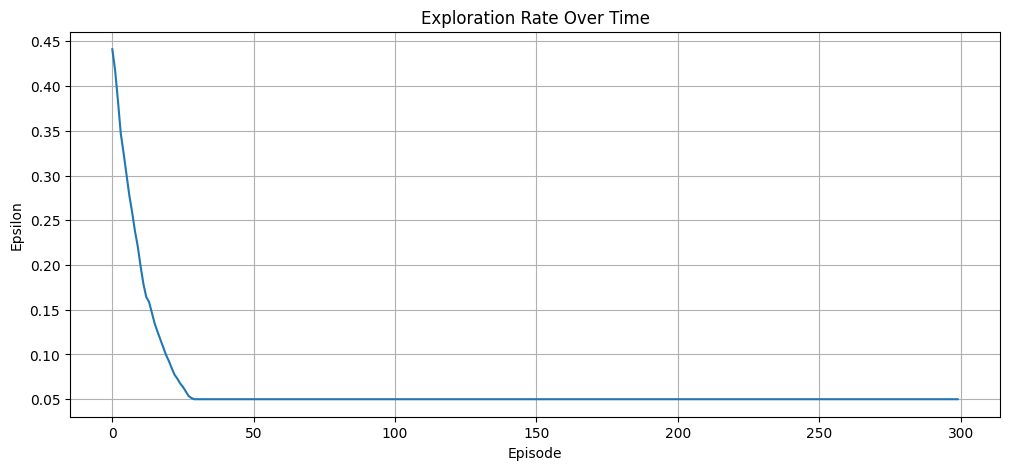

In [20]:
num_episodes = 500
batch_size = 32
gamma = 0.99
epsilon_start = 0.5
epsilon_end = 0.05
epsilon_decay = 0.995
move_nums = 1
num_games = 300
TARGET_UPDATE_EVERY = 500

import math
import chess.engine
import matplotlib.pyplot as plt
import numpy as np

engine = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")

total_captures = 0
total_checkmates = 0
total_moves_to_checkmate = 0
captures_per_episode = []
avg_moves_to_checkmate_over_time = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_network = DQN().to(device)
target_network = DQN().to(device)
target_network.load_state_dict(q_network.state_dict())

optimizer = optim.Adam(q_network.parameters(), lr=1e-4)
criterion = nn.MSELoss()

global_step = 0
epsilon = epsilon_start

episode_rewards = []
episode_epsilons = []

avg_reward_per_epoch = []

for episode in range(num_games):
    print(f"Episode {episode}")
    board = chess.Board()
    total_reward = 0
    done = False
    move_nums = 0
    turn = 1

    while not done:
        global_step += 1
        move_nums += 1

        turn = 1 if board.turn == chess.WHITE else -1
        print(f"Move {move_nums}")

        state = board_to_tensor(board, turn).to(device)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        best_move_index = select_action(board, state, q_network, epsilon)
        move = decode_move(best_move_index)
        print(f"White (Agent) plays: {move}")

        reward = get_capture_reward(board, move)
        board.push(move)
        print(f"White move: {move}")
        print(f"{board}\n")

        if not board.is_game_over():
            print("Stockfish thinking...")
            result = engine.play(board, chess.engine.Limit(time=0.1))
            black_move = result.move

            reward -= get_capture_reward(board, black_move)

            print(f"Black (Stockfish) plays: {black_move}")
            board.push(black_move)
            print(f"Black move: {black_move}")
            print(f"{board}\n")

        next_state = board_to_tensor(board, turn).to(device)

        if board.is_game_over():
            if board.result() == "1-0":
                reward = 100
            elif board.result() == "0-1":
                reward = -100
            else:
                reward = 0
            done = True

        action = best_move_index
        replay_buffer.add(state, action, reward, next_state, done)

        total_reward += reward

        if move_nums % 10 == 0 and replay_buffer.size() >= batch_size:
            print("Training on replay buffer\n")
            train(q_network, target_network, replay_buffer, batch_size, gamma, optimizer, criterion)
            print("Training complete\n")

        if global_step % TARGET_UPDATE_EVERY == 0:
            target_network.load_state_dict(q_network.state_dict())
            print("Target network updated!")

    print(f"Episode {episode}, Total Reward: {total_reward}")


    episode_rewards.append(total_reward)
    episode_epsilons.append(epsilon)



def moving_average(values, window):
    return np.convolve(values, np.ones(window)/window, mode='valid')


plt.figure(figsize=(12,6))
plt.plot(episode_rewards, alpha=0.4, label="Episode Reward")

if len(episode_rewards) >= 20:
    ma = moving_average(episode_rewards, 20)
    plt.plot(range(19, len(episode_rewards)), ma, linewidth=3, label="20-Episode Moving Avg")

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward Over Time")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(episode_epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Exploration Rate Over Time")
plt.grid(True)
plt.show()


if len(captures_per_episode) > 0:
    plt.figure(figsize=(12,5))
    plt.plot(captures_per_episode)
    plt.xlabel("Episode")
    plt.ylabel("Captures")
    plt.title("Captures Per Episode")
    plt.grid(True)
    plt.show()


Episode 0 | Reward: -107.5 | Avg (last 20): -107.50
Episode 1 | Reward: -140.5 | Avg (last 20): -124.00
Episode 2 | Reward: -130.0 | Avg (last 20): -126.00
Episode 3 | Reward: -127.5 | Avg (last 20): -126.38
Episode 4 | Reward: -122.5 | Avg (last 20): -125.60
Episode 5 | Reward: -117.5 | Avg (last 20): -124.25
Episode 6 | Reward: -113 | Avg (last 20): -122.64
Episode 7 | Reward: -100 | Avg (last 20): -119.81
Episode 8 | Reward: -107.5 | Avg (last 20): -118.44
Episode 9 | Reward: -112.5 | Avg (last 20): -117.85
Episode 10 | Reward: -138.0 | Avg (last 20): -119.68
Episode 11 | Reward: -150.5 | Avg (last 20): -122.25
Episode 12 | Reward: -102.5 | Avg (last 20): -120.73
Episode 13 | Reward: -138.0 | Avg (last 20): -121.96
Episode 14 | Reward: -140.0 | Avg (last 20): -123.17
Episode 15 | Reward: -112.5 | Avg (last 20): -122.50
Episode 16 | Reward: -132.5 | Avg (last 20): -123.09
Episode 17 | Reward: -110.0 | Avg (last 20): -122.36
Episode 18 | Reward: -128.0 | Avg (last 20): -122.66
Episode

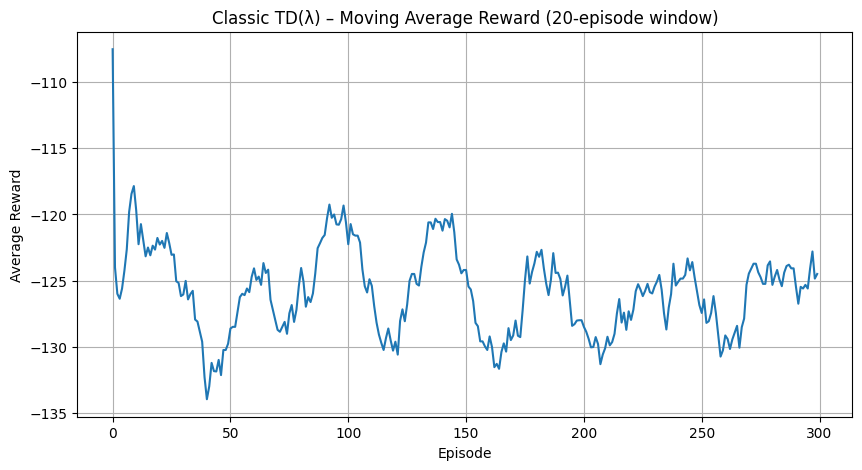

In [21]:

import numpy as np
import hashlib

from collections import defaultdict
import random


def tensor_hash(tensor):
    b = tensor.cpu().numpy().tobytes()
    return hashlib.sha256(b).hexdigest()


alpha = 0.1
gamma = 0.99
lam = 0.9
num_games = 300
V = defaultdict(float)
E = defaultdict(float)

engine = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")


def random_policy(board):
    return random.choice(list(board.legal_moves))


def compute_reward(board, move):
    reward = get_capture_reward(board, move)
    return reward

reward_history = []
avg_rewards = []

for episode in range(num_games):
    board = chess.Board()
    done = False
    E = defaultdict(float)
    total_reward = 0

    while not done:

        turn_flag = 1 if board.turn == chess.WHITE else -1
        state_tensor = board_to_tensor(board, turn_flag)
        state_key = tensor_hash(state_tensor)


        white_move = random_policy(board)
        reward = compute_reward(board, white_move)
        board.push(white_move)


        if not board.is_game_over():
            result = engine.play(board, chess.engine.Limit(time=0.1))
            black_move = result.move
            reward -= compute_reward(board, black_move)
            board.push(black_move)

        turn_flag_next = 1 if board.turn == chess.WHITE else -1
        next_state_tensor = board_to_tensor(board, turn_flag_next)
        next_state_key = tensor_hash(next_state_tensor)

        done = board.is_game_over()
        if done:
            if board.result() == "1-0":
                reward = 100
            elif board.result() == "0-1":
                reward = -100
            else:
                reward = 0

        td_target = reward + gamma * V[next_state_key] * (not done)
        delta = td_target - V[state_key]


        E[state_key] += 1

        for s in list(E.keys()):
            V[s] += alpha * delta * E[s]
            E[s] *= gamma * lam

        total_reward += reward


    reward_history.append(total_reward)
    avg_rewards.append(np.mean(reward_history[-20:]))
    print(f"Episode {episode} | Reward: {total_reward} | Avg (last 20): {avg_rewards[-1]:.2f}")

plt.figure(figsize=(10,5))
plt.plot(avg_rewards)
plt.title("Classic TD(λ) – Moving Average Reward (20-episode window)")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.grid(True)
plt.show()


In [ ]:
total_captures = 0
total_checkmates = 0
total_moves_to_checkmate = 0
captures_per_episode = []
avg_moves_to_checkmate_over_time = []

for episode in range(num_episodes):
    print(f"Episode {episode}")
    board = chess.Board()
    total_reward = 0
    done = False
    turn = 1
    move_nums = 0
    episode_captures = 0

    while not done and move_nums < 1000:
        move_nums += 1
        print(f"Episode {episode} Move {move_nums}")
        state = board_to_tensor(board, turn).to(device)

        epsilon = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * episode / epsilon_decay)
        action = select_action(board, state, q_network, epsilon)
        move = decode_move(action)

        if turn == 1:
            print(f"White move: {move}")
        else:
            print(f"Black move: {move}")

        if board.is_legal(move):
            print("Move is legal")


            if board.is_capture(move):
                episode_captures += 1

            reward = get_capture_reward(board, move)
            board.push(move)
            print(f"{board}\n")

            done = board.is_game_over()
            if done:
                result = board.result()
                if result == "1-0":
                    reward += 1000 * turn
                elif result == "0-1":
                    reward += -1000 * turn

            next_state = board_to_tensor(board, -turn).to(device)
            replay_buffer.add(state, action, reward, next_state, done)
            turn *= -1
        else:
            print("Move is illegal")
            reward = -100
            next_state = state
            replay_buffer.add(state, action, reward, next_state, done)

        total_reward += reward

        if move_nums % 4 == 0:
            print("Training on replay buffer\n")
            train(replay_buffer, batch_size, gamma)
            print("Training complete\n")

    total_captures += episode_captures
    captures_per_episode.append(episode_captures)

    if board.is_checkmate():
        total_checkmates += 1
        total_moves_to_checkmate += move_nums
        avg_moves_to_checkmate = total_moves_to_checkmate / total_checkmates
        avg_moves_to_checkmate_over_time.append(avg_moves_to_checkmate)
    else:
        avg_moves_to_checkmate_over_time.append(None)

    if episode % 7 == 0:
        target_network.load_state_dict(q_network.state_dict())
        print(f"Episode {episode}, Total Reward: {total_reward}")

        avg_captures = total_captures / (episode + 1)
        print(f"Average captures per episode: {avg_captures:.2f}")
        if total_checkmates > 0:
            print(f"Average moves to checkmate: {avg_moves_to_checkmate:.2f}")
        else:
            print("No checkmates yet")


NameError: name 'num_episodes' is not defined

In [ ]:
torch.save(q_network.state_dict(), "q_network.pth")
torch.save(target_network.state_dict(), "target_network.pth")


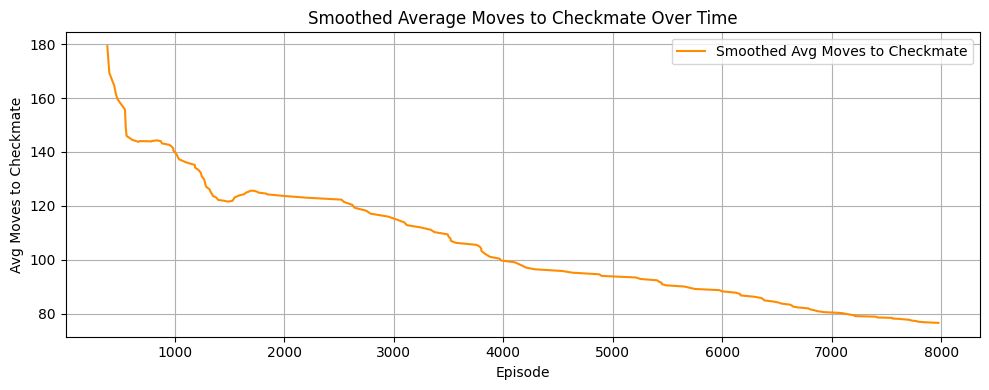

In [ ]:
# @title
import numpy as np

def moving_average(y_vals, window=10):
    y_vals = np.array(y_vals, dtype=np.float32)
    weights = np.ones(window) / window
    return np.convolve(y_vals, weights, mode='valid')

# Filter out None values and align their episode numbers
episodes = []
values = []
for i, v in enumerate(avg_moves_to_checkmate_over_time):
    if v is not None:
        episodes.append(i)
        values.append(v)

if len(values) >= 2:
    smoothed_values = moving_average(values, window=10)
    smoothed_episodes = episodes[len(episodes) - len(smoothed_values):]

    plt.figure(figsize=(10, 4))
    plt.plot(smoothed_episodes, smoothed_values, label='Smoothed Avg Moves to Checkmate', color='darkorange')
    plt.xlabel('Episode')
    plt.ylabel('Avg Moves to Checkmate')
    plt.title('Smoothed Average Moves to Checkmate Over Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


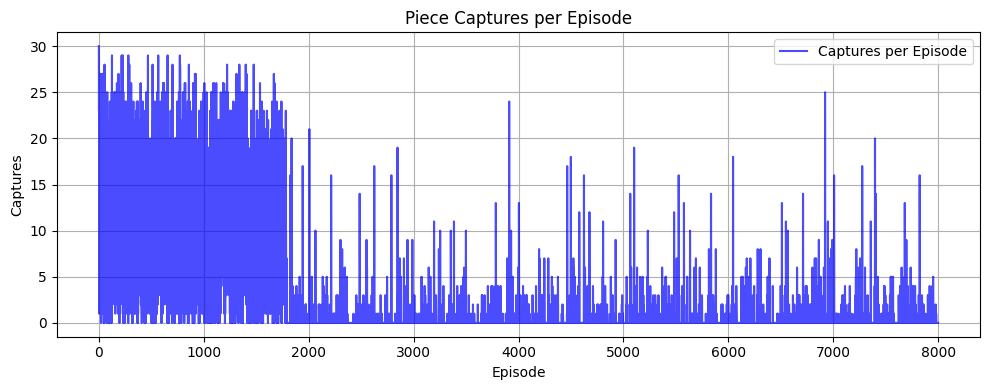

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(captures_per_episode, label='Captures per Episode', color='blue', alpha=0.7)
plt.xlabel('Episode')
plt.ylabel('Captures')
plt.title('Piece Captures per Episode')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
